# 05a - Correlations between relaxed and unrelaxed data for copper facets

This notebook reproduces Figs. 5a-c from the manuscript and Figs. S15-S20 from the Supporting Information. The data in this notebook illustrates the correlations between relaxed and unrelaxed data for the copper facets under study.

In [1]:
from basics import *
from plotting import *
from scipy import stats
from ase import Atoms
from mkite_catalysis.runners.deduplicate import Deduplicator

plt.style.use("paper")

## Loading the data

In [2]:
data = pd.read_json("../data/231003-COv-data.json.gz", compression="gzip")

In [3]:
FACETS = [100, 111, 211, 331, 410, 711]
NADS = np.arange(1, 19)
facet_idx = {
    100: 0,
    111: 1,
    211: 2,
    331: 3,
    410: 4,
    711: 5,
}

## Correlation between unrelax and relax energies

In [4]:
df = data.dropna()

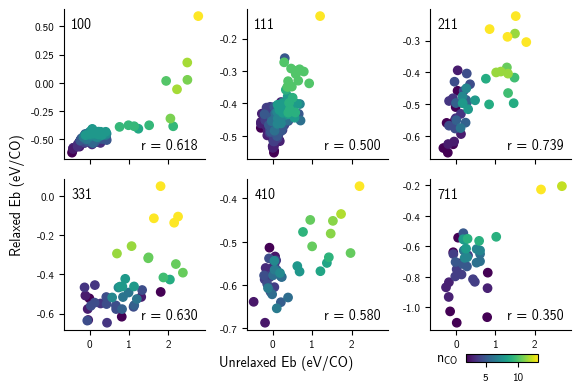

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=True)

bins = np.linspace(-0.5, 5, 30)

for ax, (facet, grp) in zip(axs.reshape(-1), df.groupby("facet")):
    j = facet_idx[facet]
    _x = grp["unrelax_binding_site"]
    _y = grp["relax_binding_site"]
    sc = ax.scatter(_x, _y, c=grp["num_adsorbates"], cmap="viridis")
    r, _ = stats.spearmanr(_x, _y)
    ax.annotate(facet, (0.05, 0.95), xycoords="axes fraction", ha="left", va="top", color="k")
    ax.annotate(
        f"r = {r:.3f}",
        (0.95, 0.05),
        xycoords="axes fraction",
        ha="right",
        va="bottom",
        color="k"
    )

cax = fig.add_axes([0.80, 0.08, 0.12, 0.02])
cbar = fig.colorbar(sc, cax=cax, orientation="horizontal")
fig.text(0.75, 0.08, "n$_{CO}$")

fig.supxlabel("Unrelaxed Eb (eV/CO)", y=0.06, fontsize=10)
fig.supylabel("Relaxed Eb (eV/CO)", x=0.04, fontsize=10)
fig.tight_layout()
savefig(fig, "01-dset-relax-corr.pdf")
plt.show()

### Recall of relaxed energies given unrelaxed ones

In [6]:
def recall_curve(xy, top_n=5):
    """
    Calculate the recall curve for a xyset of (x, y) points.

    :param xy: A numpy array of shape (m, 2) containing (x, y) points.
    :param n_values: A list of n values for which to calculate recall.
    :return: A numpy array of shape (len(n_values), 2) containing (n, recall) pairs.
    """
    sorted_by_x = xy[xy[:, 0].argsort()]  # Sort xy by x values
    sorted_by_y = xy[xy[:, 1].argsort()]  # Sort xy by y values
    top_y_values = set(sorted_by_y[:top_n, 1])

    N = len(xy)
    recall_values = []
    for n in range(0, N + 1):
        recalled_y_values = set(sorted_by_x[:n, 1])
        recall = len(recalled_y_values & top_y_values) / top_n
        recall_values.append([n / N, recall])

    return np.array(recall_values) * 100

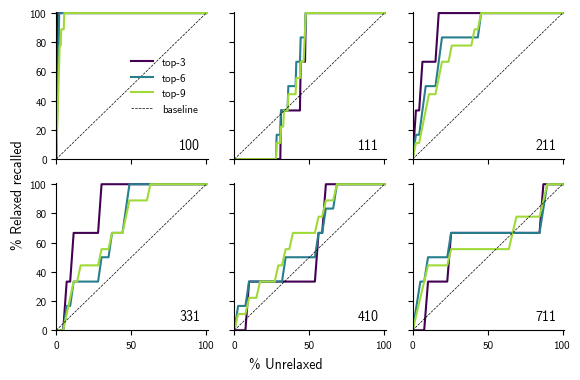

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=True, sharey=True)

norm = plt.Normalize(3, 10)
cmap = lambda x: cm.viridis(norm(x))

for ax, (facet, grp) in zip(axs.reshape(-1), df.groupby("facet")):
    j = facet_idx[facet]
    xy = grp[["unrelax_binding_site", "relax_binding_site"]].values
    
    for n in [3, 6, 9]:
        recall = recall_curve(xy, top_n=n)
        pl = ax.plot(recall[:, 0], recall[:, 1], color=cmap(n), label=f"top-{n}")
        
    ax.set_xlim(0, 101)
    ax.set_ylim(0, 101)
    ax.plot([0, 100], [0, 100], "k--", linewidth=0.5, label="baseline")
    ax.annotate(facet, (0.95, 0.05), xycoords="axes fraction", ha="right", va="bottom")

fig.supxlabel("% Unrelaxed", y=0.06, fontsize=10)
fig.supylabel("% Relaxed recalled", x=0.04, fontsize=10)

axs[0, 0].legend(frameon=False, loc="center right")

fig.tight_layout()
savefig(fig, "01-dset-relax-recall.pdf")
plt.show()

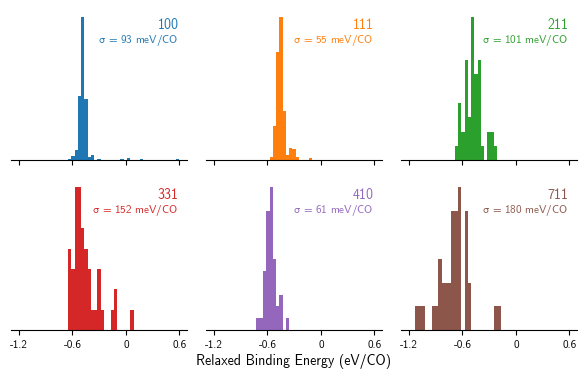

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=True)

bins = np.linspace(-1.2, 0.6, 50)

for ax, (facet, grp) in zip(axs.reshape(-1), df.groupby("facet")):
    j = facet_idx[facet]
    
    e = grp["relax_binding_site"]
    
    std = np.std(e) * 1000
    
    ax.hist(e, bins=bins, color=cm.tab10(j))
    ax.annotate(facet, (0.95, 0.95), xycoords="axes fraction", ha="right", va="top", color=cm.tab10(j))
    ax.annotate(
        f"$\sigma$ = {std:.0f} meV/CO",
        (0.95, 0.85),
        xycoords="axes fraction",
        ha="right",
        va="top",
        color=cm.tab10(j),
        fontsize=8
    )

for ax in axs.reshape(-1):
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for ax in axs[-1, :]:
    ticks = [-1.2, -0.6, 0, 0.6]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, fontsize=8)

fig.supxlabel("Relaxed Binding Energy (eV/CO)", y=0.065, fontsize=10)
fig.tight_layout()
savefig(fig, "01-dset-delta-distr.pdf")
plt.show()

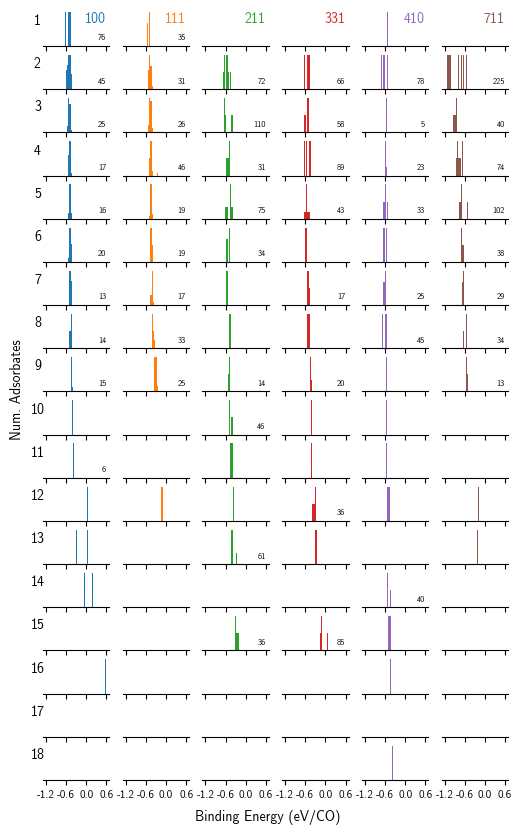

In [9]:
fig, axs = plt.subplots(18, 6, figsize=(6, 10), sharex=True)

facets = [100, 111, 211, 331, 410, 711]
adsorbates = np.arange(1, 19)

bins = np.linspace(-1.2, 0.6, 50)

for facet, nads in itertools.product(facets, adsorbates):
    i, j = nads - 1, facet_idx[facet]
    ax = axs[i, j]
    grp = df.loc[(df.facet == facet) & (df.num_adsorbates == nads)]
    
    if len(grp) > 0:
        e = grp["relax_binding_site"]
        ax.hist(e, bins=bins, color=cm.tab10(j))
        
        if len(grp) > 2:
            ax.annotate(
                f"{e.std() * 1000:.0f}",
                (0.95, 0.10),
                xycoords="axes fraction",
                ha="right",
                va="bottom",
                fontsize=6,
            )
    
    if i == 0:
        ax.annotate(facet, (0.95, 0.95), xycoords="axes fraction", ha="right", va="top", color=cm.tab10(j))

for ax in axs.reshape(-1):
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for ax in axs[-1, :]:
    ticks = [-1.2, -0.6, 0.0, 0.6]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, fontsize=8)
#     ax.set_xlabel("E$_b$ (eV/CO)", fontsize=10)
    
for i, ax in enumerate(axs[:, 0], 1):
    ax.set_ylabel(i, rotation=0)

fig.supxlabel("Binding Energy (eV/CO)", y=0.065, fontsize=10)
fig.supylabel("Num. Adsorbates", x=0.07, fontsize=10)

savefig(fig, "01-dset-delta-splits.pdf")
plt.show()

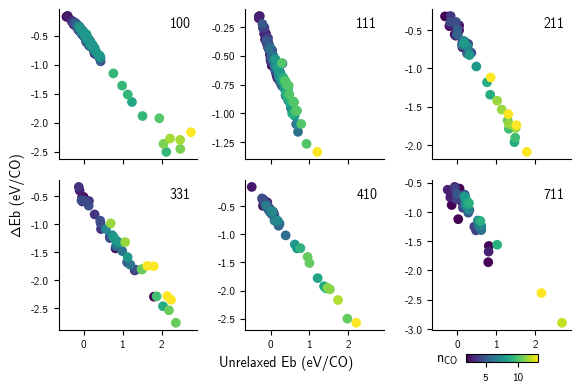

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=True)

bins = np.linspace(-0.5, 5, 30)

for ax, (facet, grp) in zip(axs.reshape(-1), df.groupby("facet")):
    j = facet_idx[facet]

    sc = ax.scatter(
        grp["unrelax_binding_site"],
        grp["relax_binding_site"] - grp["unrelax_binding_site"],
        c=grp["num_adsorbates"],
        cmap="viridis"
    )
    ax.annotate(facet, (0.95, 0.95), xycoords="axes fraction", ha="right", va="top", color="k")

cax = fig.add_axes([0.80, 0.08, 0.12, 0.02])
cbar = fig.colorbar(sc, cax=cax, orientation="horizontal")
fig.text(0.75, 0.08, "n$_{CO}$")

fig.supxlabel("Unrelaxed Eb (eV/CO)", y=0.06, fontsize=10)
fig.supylabel("ΔEb (eV/CO)", x=0.04, fontsize=10)
fig.tight_layout()
savefig(fig, "01-dset-delta-corr.pdf")
plt.show()

## Comparing $\Delta E_b$ and PDD

In [11]:
def get_atoms(adict):
    numbers = np.array(adict["numbers"])
    positions = np.array(adict["positions"])
    
    return Atoms(
        numbers=numbers,
        positions=positions,
        cell=adict["cell"],
        pbc=adict["pbc"],
    )

def get_pdd_distance(atoms, k=50):
    dedup = Deduplicator(k=k)
    pdds = dedup.get_pdds(atoms)        
    dm = dedup.get_pdd_distance_matrix(pdds)
    return dm[0, 1]

In [12]:
distances = []
for _, row in tqdm.tqdm(df.iterrows()):
    at_u = get_atoms(row["unrelax_atoms"])
    at_r = get_atoms(row["relax_atoms"])
    dist = get_pdd_distance([at_u, at_r], k=50)
    distances.append(dist)

df.loc[:, "pdd"] = distances

675it [00:29, 22.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


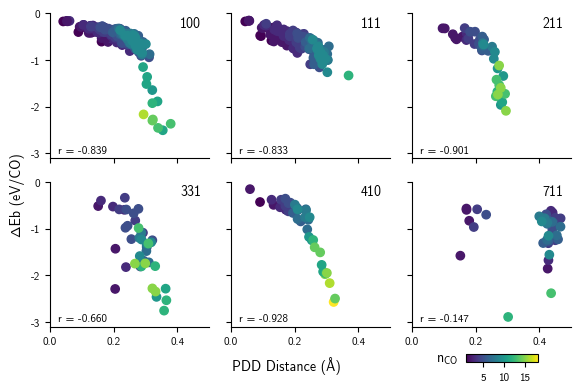

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=True, sharey=True)

norm = plt.Normalize(1, 18)

for facet, grp in df.groupby("facet"):
    i = facet_idx[facet]
    ax = axs.reshape(-1)[i]
    _x = grp["pdd"]
    _y = grp["relax_binding_site"] - grp["unrelax_binding_site"]
    
    sc = ax.scatter(_x, _y, c=grp["num_adsorbates"], norm=norm)
    
    r, _ = stats.spearmanr(_x, _y)
    
    ax.annotate(
        f"r = {r:.3f}",
        (0.05, 0.02),
        xycoords="axes fraction",
        ha="left",
        va="bottom",
        fontsize=8
    )
    ax.annotate(
        facet,
        (0.95, 0.98),
        xycoords="axes fraction",
        ha="right",
        va="top",
        fontsize=10
    )
    ax.set_xlim(0, 0.5)
    ax.set_ylim(-3.1, 0)
    
cax = fig.add_axes([0.80, 0.08, 0.12, 0.02])
cbar = fig.colorbar(sc, cax=cax, orientation="horizontal")
fig.text(0.75, 0.08, "n$_{CO}$")

fig.supxlabel("PDD Distance (Å)", y=0.05, fontsize=10)
fig.supylabel("ΔEb (eV/CO)", x=0.04, fontsize=10)
fig.tight_layout()
savefig(fig, "01-dset-delta-pdd.pdf")
plt.show()